## Accessing 3DEP Seamless DEM data with the Planetary Computer STAC API

### Environment setup

This notebook works with or without a Planetary Computer subscription key, but you will be given more permissive access to the data with a key. The Planetary Computer Hub is pre-configured to use your key.

In [1]:
import planetary_computer
import pystac_client

### Open and explore the 3dep-seamless collection

[3DEP](https://planetarycomputer.microsoft.com/dataset/3dep-seamless) is a national elevation dataset program from the [USGS](https://www.usgs.gov/core-science-systems/ngp/3dep).
It provides elevation data for the entire United States using a wide variety of survey methods, including modern lidar airborne surveys.
The Planetary Computer hosts seamless elevation Digital Elevation Models (DEMs) at two resolutions, 1/3 arc-second and 1 arc-second.

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
threedep = catalog.get_child(id="3dep-seamless")

The 3DEP seamless dataset covers the entire United States, as you can see from the bounds:

In [6]:
threedep.extent.spatial.to_dict()

{'bbox': [[-174.001666666983,
   -15.00166666667,
   164.0016666666,
   84.00166666666]]}

### Plotting elevation data

Let's take a look at Mt. Shasta in Northern California.
We define a point, then find a bounding box around that point.
The query area for this example is pretty small, and we will only fetch one tile — you can increase the buffer size and this example should work with multiple tiles (though the plotting will take longer).

In [7]:
latitude = 41.41505315463394
longitude = -122.19468933831948
buffer = 0.1
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
search = catalog.search(collections="3dep-seamless", bbox=bbox)
items = list(search.get_items())
print(f"{len(items)} items found")

2 items found


The Planetary Computer hosts both the 1 arc-second (nominal 30m pixel size) and 1/3 arc-second (nominal 10m pixel size) resolution 3DEP data.
Let's seperate the two sets into their own lists by filtering on the Ground Sample Distance (GSD) in the STAC items.

We'll also [sign the assets](../quickstarts/reading-stac.ipynb) before downloading, which can be done with or without a Planetary Computer subscription key.

In [12]:
items_low_res = [item.to_dict() for item in items if item.properties["gsd"] == 30]
items_high_res = [item.to_dict() for item in items if item.properties["gsd"] == 10]

DEMs are relatively simple raster datsets — they only have one band (elevation). Let's compare visualizations of high and low resolution images for our area of interest.
We'll read the items into a DatayArray using [`stackstac`](https://stackstac.readthedocs.io/), taking care to crop the larger assets down to our area of interest.

In [13]:
import stackstac

low_res_data = stackstac.stack(items_low_res, bounds=bbox).squeeze().compute()
high_res_data = stackstac.stack(items_high_res, bounds=bbox).squeeze().compute()

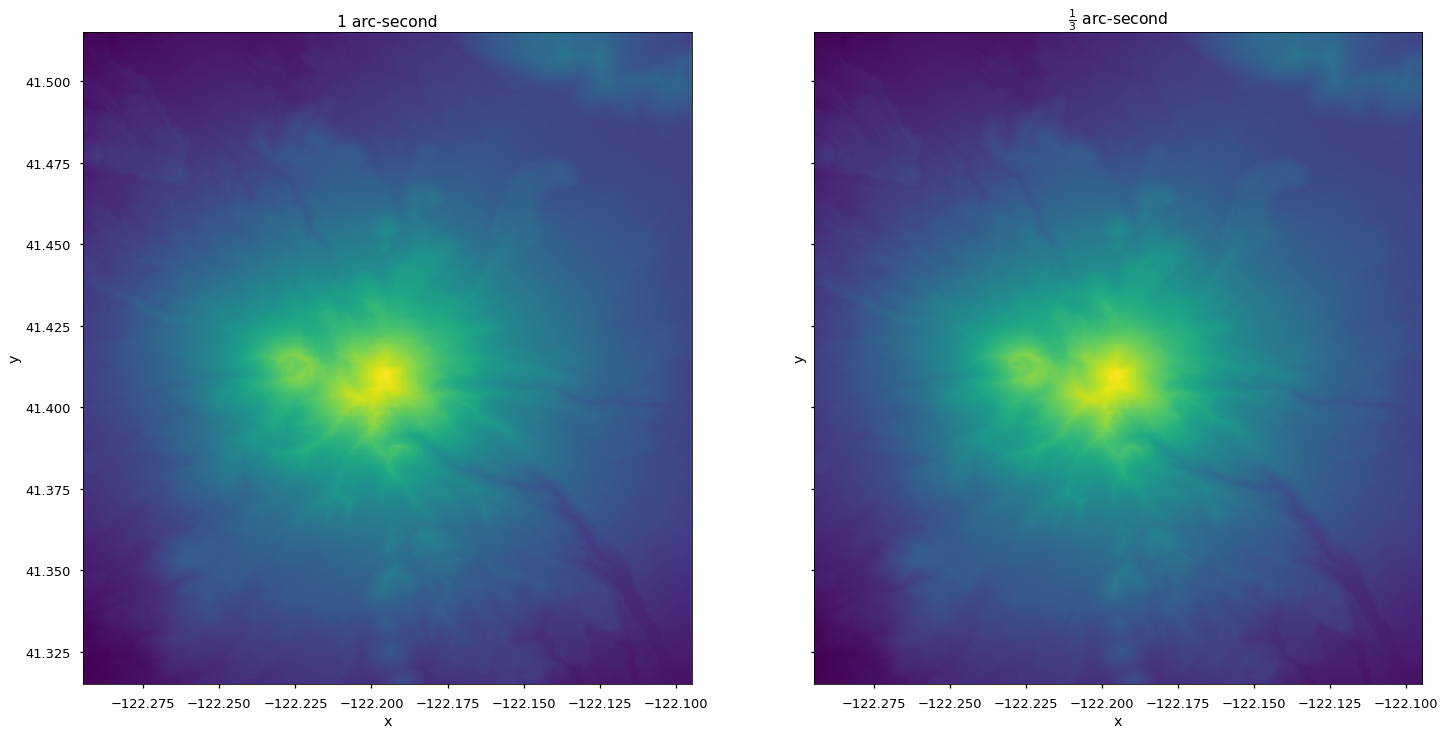

In [14]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-talk")

fig, axes = plt.subplots(ncols=2, figsize=(24, 12), sharex=True, sharey=True)
low_res_data.plot.imshow(ax=axes[0], add_colorbar=False)
high_res_data.plot.imshow(ax=axes[1], add_colorbar=False)

axes[0].set(title="1 arc-second")
axes[1].set(title=r"$\frac{1}{3}$ arc-second");